In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
import numpy as np
import fpfs
import matplotlib.pyplot as plt

import batsim.pltutil as batplot
from batsim.stamp import Stamp
from batsim.transforms import IaTransform, LensTransform

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### Fit A_IA galaxy scale dependence

[0.00136207 0.82404653]
0.0006810368032051805
0.72546888871855
0.72546888871855
0.7254688887185501


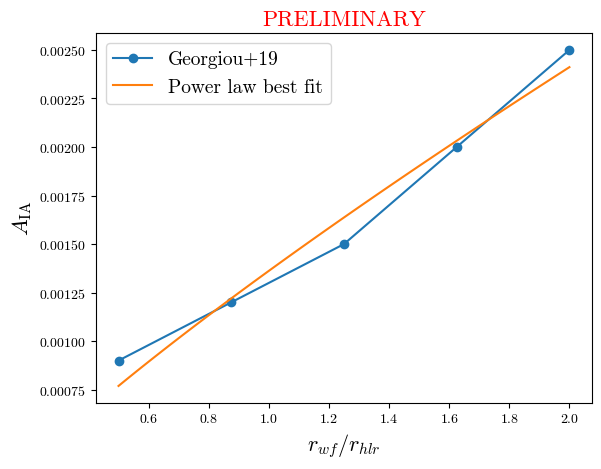

In [13]:
# fit curve to GAMA results in Georgieu 2019
from scipy.optimize import curve_fit

rwf = np.linspace(0.5,2.0,5)

A_IA = [0.0009, 0.0012, 0.0015, 0.002, 0.0025]

def power_law(rwf, m, b):
    return m * rwf**b

var, covs = curve_fit(power_law, rwf, A_IA)
print(var)
rwf_dense = np.linspace(0.5,2.0,100)
A_dense = var[0] * rwf_dense**var[1]
A_dense_2 = 2*var[0] * rwf_dense**var[1]
A_dense_3 = 3*var[0] * rwf_dense**var[1]
A_dense_10 = 10*var[0] * rwf_dense**var[1]

AIA_fid = galsim.Shear(e1=var[0]).g1
print(AIA_fid)

plt.plot(rwf, A_IA, marker='o', label='Georgiou+19')
plt.plot(rwf_dense, A_dense, label='Power law best fit')
plt.legend(fontsize=14)
plt.ylabel(r'$A_{\rm IA}$', fontsize=16)
plt.xlabel(r'$r_{wf}/r_{hlr}$', fontsize=16)
plt.title('PRELIMINARY', fontsize=16, color='red')
plt.savefig('A_IA_fit.pdf', bbox_inches='tight', dpi=300)

print(A_dense[30]/A_dense[60])
print(A_dense_2[30]/A_dense_2[60])
print(A_dense_3[30]/A_dense_3[60])

### Test with a power of 0 (constant shear)

8.533333333333333


Text(0.5, 1.0, 'Preliminary')

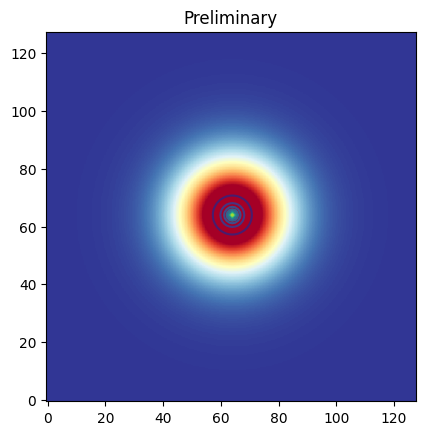

In [4]:
## create a galaxy with raidall dependent shear
flux = 40
scale = 0.2
hlr = 1.5
nn = 128
trunc = 0

print((nn/2 * scale )/ hlr)

# create galaxy to be sampled by shear stamp objects
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux, trunc=trunc)

# # # apply lensing shear to galaxy
stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

# define ia shear as a % of lensing
ia = IaTransform(beta=0, center=[0,0], phi=np.radians(0), scale=scale, hlr=hlr)
stamp.transform_grids(ia)

# get galaxy array from stamp object
gal_array = stamp.sample_galaxy(sersic_gal)
batplot.make_plot_image(gal_array)
plt.contour(gal_array, levels=15)
plt.title('Preliminary')

In [37]:
# define PSF
psf_array = np.zeros(stamp.shape)
psf_array[nn // 2, nn // 2] = 1

coords = np.array([nn//2, nn//2])
fpTask  = fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

inner_shear = shear

2023/12/01 11:15:37 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:37 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:37 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:37 ---  Maximum |k| is 2.307


measured shear: 0.000682


In [38]:
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

outer_shear = shear

2023/12/01 11:15:39 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:39 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:15:39 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:15:39 ---  Maximum |k| is 1.227


measured shear: 0.000681


In [39]:
print('a =', inner_shear / outer_shear)
print('Fiducial AIA value', AIA_fid)
print('inner bias = ', AIA_fid - inner_shear)
print('outer bias = ', AIA_fid - outer_shear)

a = 1.001014459249826
Fiducial AIA value 0.0006810368032051805
inner bias =  -7.865467886619985e-07
outer bias =  -9.556575661286842e-08


### Now test with non-zero index

Text(0.5, 1.0, 'Preliminary')

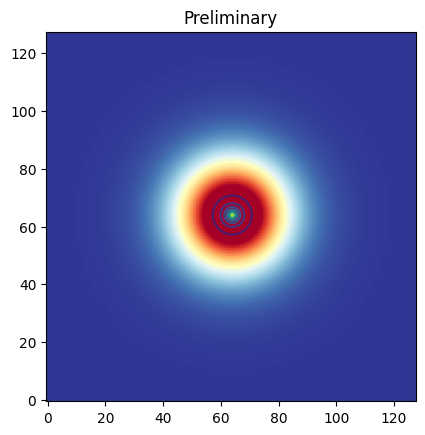

In [40]:
# # # apply lensing shear to galaxy
stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

# define ia shear as a % of lensing
ia = IaTransform(A=0.00136207, center=[0,0], scale=scale, hlr=hlr)
stamp.transform_grids(ia)

# get galaxy array from stamp object
gal_array = stamp.sample_galaxy(sersic_gal)
batplot.make_plot_image(gal_array)
plt.contour(gal_array, levels=15)
plt.title('Preliminary')

In [41]:
coords = np.array([nn//2, nn//2])
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

inner_shear = shear

2023/12/01 11:15:44 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:44 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:44 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:44 ---  Maximum |k| is 2.307


measured shear: 0.000492


In [42]:
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

outer_shear = shear

2023/12/01 11:15:45 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:45 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:15:45 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


2023/12/01 11:15:45 ---  Maximum |k| is 1.227


measured shear: 0.000791


In [43]:
print('a =', inner_shear / outer_shear)

a = 0.6215632574644877


In [44]:
# check measurement at assumed half light radius

fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.957)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

print(AIA_fid - shear)

2023/12/01 11:15:48 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:48 ---  Shapelet kernel in configuration space: sigma= 0.9570 arcsec
2023/12/01 11:15:48 ---  Detection kernel in configuration space: sigma= 0.9570 arcsec
2023/12/01 11:15:48 ---  Maximum |k| is 1.424


measured shear: 0.000681
-1.7844568452420918e-07


### Test ratio is constant for different input amplitudes, scales etc.

In [45]:
def test_amplitudes(A_IA):
    
    # # # apply lensing shear to galaxy
    stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

    # define ia shear as a % of lensing
    ia = IaTransform(A=A_IA, center=[0,0], scale=scale, hlr=hlr)
    stamp.transform_grids(ia)

    # get galaxy array from stamp object
    gal_array = stamp.sample_galaxy(sersic_gal)
    
    return gal_array

In [46]:
# test a constancy for differnt amps
A_IAs = np.linspace(0.000536207,0.0136207,50)

a_amps = []
diffs = []
for A_IA in A_IAs:
    
    gal_array = test_amplitudes(A_IA)
    
    coords = np.array([nn//2, nn//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    inner_shear=np.average(ells['fpfs_e1'])/resp
    
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    outer_shear=np.average(ells['fpfs_e1'])/resp
    
    a_amps.append(inner_shear / outer_shear)
    
    diffs.append(outer_shear - inner_shear)

2023/12/01 11:15:50 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:50 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:50 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:50 ---  Maximum |k| is 2.307
2023/12/01 11:15:51 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:51 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:15:51 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:15:51 ---  Maximum |k| is 1.227
2023/12/01 11:15:51 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:51 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:51 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:15:51 ---  Maximum |k| is 2.307
2023/12/01 11:15:51 ---  Order of the shear estimator: nnord=4
2023/12/01 11:15:51 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/

Max percentage change in a 0.011246088422113217


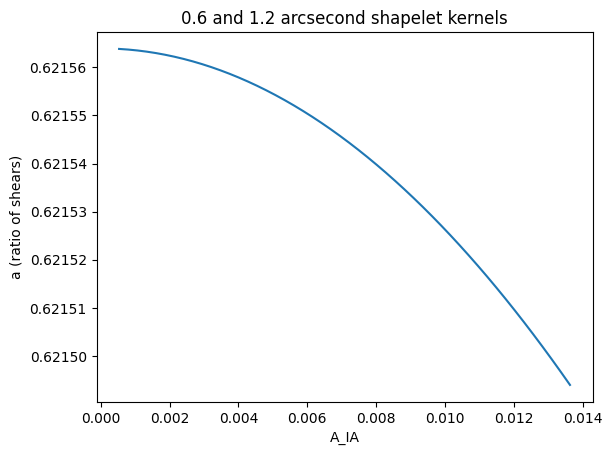

In [47]:
plt.plot(A_IAs, a_amps)
#plt.ylim([0.61,0.63])
plt.xlabel('A_IA')
plt.ylabel('a (ratio of shears)')
plt.title('0.6 and 1.2 arcsecond shapelet kernels')

perc_var = ((max(a_amps) - min(a_amps)) / min(a_amps)) * 100 
print('Max percentage change in a', perc_var)

Max percentage change in estimated yIA 0.01846910224918696


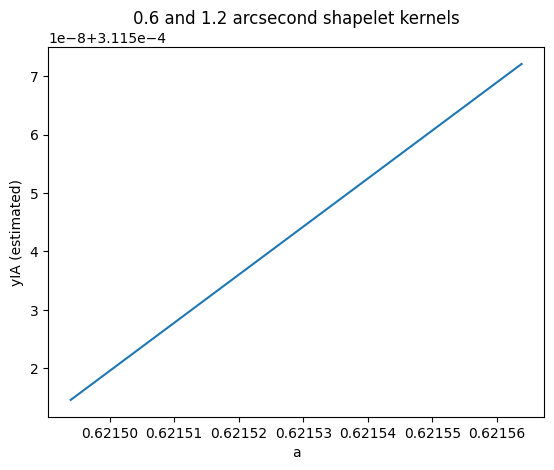

In [48]:
min_diff = min(diffs)
estimated_yIA = min_diff / (1-np.asarray(a_amps))

plt.plot(a_amps, estimated_yIA)
# plt.ylim([0.000158,0.0001584])
plt.xlabel('a')
plt.ylabel('yIA (estimated)')
plt.title('0.6 and 1.2 arcsecond shapelet kernels')

perc_var = ((max(estimated_yIA) - min(estimated_yIA)) / min(estimated_yIA)) * 100 
print('Max percentage change in estimated yIA', perc_var)

In [54]:
def test_scales(scale):

    # fix galaxy size relative to stamp by adding more pixels
    # nn should be 8.533... times large than galaxy
    nn = int((hlr * 17.6)/scale)

    # apply lensing shear to galaxy
    stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

    # define ia shear as a % of lensing
    ia = IaTransform(center=[0,0], scale=scale, hlr=hlr)
    stamp.transform_grids(ia)
    
    # get galaxy array from stamp object
    gal_array = stamp.sample_galaxy(sersic_gal)
    
    # define PSF
    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    
    coords = np.array([nn//2, nn//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    inner_shear=np.average(ells['fpfs_e1'])/resp
    
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    outer_shear=np.average(ells['fpfs_e1'])/resp
    
    a = inner_shear / outer_shear
    
    inner = inner_shear
    outer  = outer_shear
          
    return a, inner, outer 

In [55]:
scales = np.linspace(0.2,0.005,10)

a_scale = []
in_bias_scale = []
out_bias_scale = []

for scale in scales:
    
    a, inner, outer = test_scales(scale)
    
    a_scale.append(a)
    in_bias_scale.append(inner)
    out_bias_scale.append(outer)
    

2023/12/01 11:21:06 ---  Order of the shear estimator: nnord=4
2023/12/01 11:21:06 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:21:06 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:21:06 ---  Maximum |k| is 2.285
2023/12/01 11:21:07 ---  Order of the shear estimator: nnord=4
2023/12/01 11:21:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:21:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 11:21:07 ---  Maximum |k| is 1.238
2023/12/01 11:21:07 ---  Order of the shear estimator: nnord=4
2023/12/01 11:21:07 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:21:07 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/12/01 11:21:07 ---  Maximum |k| is 2.038
2023/12/01 11:21:08 ---  Order of the shear estimator: nnord=4
2023/12/01 11:21:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/

Max percentage variation in a 0.04392321294845025


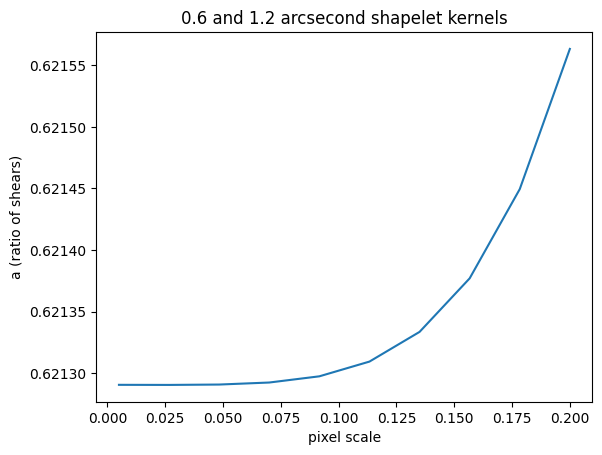

In [57]:
plt.plot(scales, a_scale)
#plt.axhline(np.mean(a_scale), ls='--', c='black')
#plt.ylim([min(a_scale),max(a_scale)])
plt.xlabel('pixel scale')
plt.ylabel('a (ratio of shears)')
plt.title('0.6 and 1.2 arcsecond shapelet kernels')

perc_var = (max(a_scale) - min(a_scale)) / min(a_scale) * 100
print('Max percentage variation in a', perc_var)

Text(0.5, 1.0, 'Measured shear, 0.6 shapelet kernel')

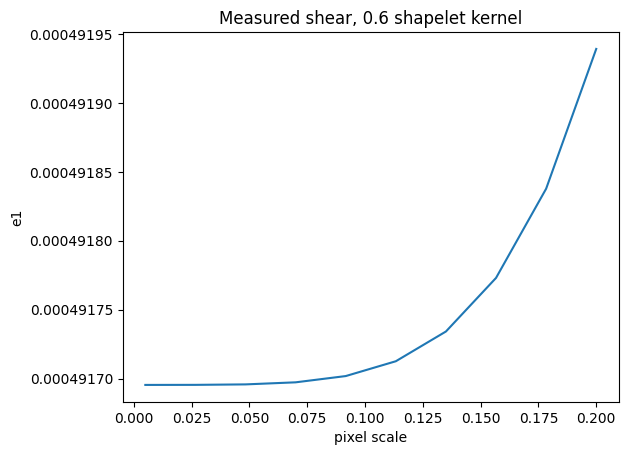

In [59]:
plt.plot(scales, in_bias_scale)
#plt.plot(scales, out_bias_scale)
plt.xlabel('pixel scale')
plt.ylabel('e1')
plt.title('Measured shear, 0.6 shapelet kernel')

Text(0.5, 1.0, 'Measured shear, 1.2 shapelet kernel')

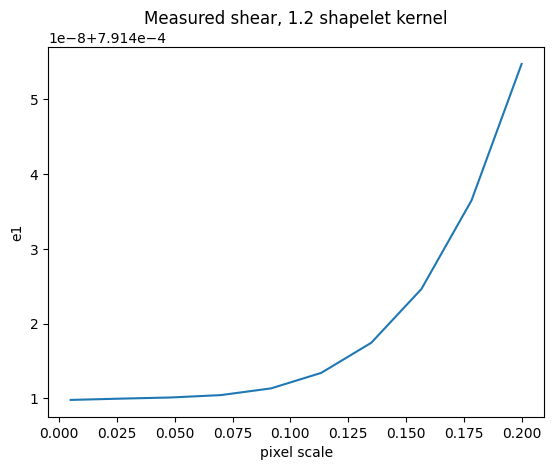

In [61]:
size_ratios = scales / hlr
plt.plot(scales, out_bias_scale)
plt.xlabel('pixel scale')
plt.ylabel('e1')
plt.yticks
plt.title('Measured shear, 1.2 shapelet kernel')

## Determine relationship between measurment accuracy at outer radii and hlr / (npixel/2 * scale) ratio
- For a galaxy of given halflight radius we require that the stamp on which it is simulated be X times larger than the galaxy


In [22]:
def test_relative_size(factor):

    # fix galaxy size relative to stamp by adding more pixels
    # nn should be 8.533... times large than galaxy
    nn = 64
    scale = 0.01 * factor

    # apply lensing shear to galaxy
    stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

    ia = IaTransform(beta=0, center=[0,0], scale=scale, hlr=hlr)
    stamp.transform_grids(ia)
    
    # get galaxy array from stamp object
    gal_array = stamp.sample_galaxy(sersic_gal)
    
    # define PSF
    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    
    fpTask = fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
    mms = fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp = np.average(ells['fpfs_R1E'])
    outer_shear = np.average(ells['fpfs_e1'])/resp

    size_ratio = (nn/2 * scale) / hlr
    bias = abs(outer_shear - AIA_fid)
    print(bias, size_ratio)
    return size_ratio, bias

In [23]:
factors = np.linspace(1,40,40)

size_ratios = []
biases = []
for factor in factors:
    
    size_ratio, bias = test_relative_size(factor)
    size_ratios.append(size_ratio)
    biases.append(bias)

2023/12/01 10:26:03 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:03 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:03 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:03 ---  Maximum |k| is 1.178
2023/12/01 10:26:04 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:04 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Maximum |k| is 1.178


8.975877454230153e+30 2.909090909090909
0.0006948588324558371 5.818181818181818


2023/12/01 10:26:04 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:04 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Maximum |k| is 1.178
2023/12/01 10:26:04 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:04 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Maximum |k| is 1.178


0.0007007507308981822 8.727272727272727
0.000707596351461081 11.636363636363637


2023/12/01 10:26:04 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:04 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:04 ---  Maximum |k| is 1.178
2023/12/01 10:26:05 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:05 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Maximum |k| is 1.178


0.0007160074854892086 14.545454545454547
0.0007348153663409202 17.454545454545453


2023/12/01 10:26:05 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:05 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Maximum |k| is 1.178
2023/12/01 10:26:05 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:05 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Maximum |k| is 1.178


0.0008143411819260564 20.363636363636367
0.0017375935105058042 23.272727272727273


2023/12/01 10:26:05 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:05 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Maximum |k| is 1.178
2023/12/01 10:26:05 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:05 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:05 ---  Maximum |k| is 1.178


0.00027948765717096655 26.18181818181818
3.411719691024729e-05 29.090909090909093


2023/12/01 10:26:06 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Maximum |k| is 1.178
2023/12/01 10:26:06 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Maximum |k| is 1.178


1.5939483238054143e-05 32.0
1.891424179903433e-05 34.90909090909091


2023/12/01 10:26:06 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Maximum |k| is 1.178
2023/12/01 10:26:06 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Maximum |k| is 1.178


2.457800541780838e-05 37.81818181818182
3.131522661327911e-05 40.727272727272734


2023/12/01 10:26:06 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Maximum |k| is 1.178
2023/12/01 10:26:06 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:06 ---  Maximum |k| is 1.178


3.903599643771661e-05 43.63636363636363
4.7742359462982415e-05 46.54545454545455


2023/12/01 10:26:07 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Maximum |k| is 1.178
2023/12/01 10:26:07 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Maximum |k| is 1.178


5.743243301524741e-05 49.45454545454546
6.809135408987509e-05 52.36363636363636


2023/12/01 10:26:07 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Maximum |k| is 1.178
2023/12/01 10:26:07 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Maximum |k| is 1.178


7.97064137665639e-05 55.27272727272727
9.2251672626503e-05 58.18181818181819


2023/12/01 10:26:07 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:07 ---  Maximum |k| is 1.276
2023/12/01 10:26:08 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Maximum |k| is 1.276


0.00010570264789236622 61.090909090909086
0.00012002582447173627 64.0


2023/12/01 10:26:08 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Maximum |k| is 1.374
2023/12/01 10:26:08 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Maximum |k| is 1.374


0.00013519265128949566 66.9090909090909
0.00015116130656655895 69.81818181818181


2023/12/01 10:26:08 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:08 ---  Maximum |k| is 1.473
2023/12/01 10:26:09 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:09 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:09 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:09 ---  Maximum |k| is 1.473


0.0001679108372461312 72.72727272727273
0.00018538079302823744 75.63636363636364


2023/12/01 10:26:09 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:09 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:09 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:09 ---  Maximum |k| is 1.571
2023/12/01 10:26:09 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:09 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:09 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:09 ---  Maximum |k| is 1.669


0.00020357879800946195 78.54545454545455


2023/12/01 10:26:10 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:10 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Maximum |k| is 1.669


0.00022243285014343736 81.45454545454547


2023/12/01 10:26:10 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:10 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Maximum |k| is 1.767


0.0002419151849308534 84.36363636363636


2023/12/01 10:26:10 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:10 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Maximum |k| is 1.767


0.0002620096483858176 87.27272727272727


2023/12/01 10:26:10 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:10 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:10 ---  Maximum |k| is 1.865


0.0002826574715464491 90.18181818181819


2023/12/01 10:26:11 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:11 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:11 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:11 ---  Maximum |k| is 1.963


0.000303875020315758 93.0909090909091


2023/12/01 10:26:11 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:11 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:11 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:11 ---  Maximum |k| is 1.963


0.00032559334581973136 96.0


2023/12/01 10:26:11 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:11 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:11 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:11 ---  Maximum |k| is 2.062


0.0003477818908512194 98.90909090909092


2023/12/01 10:26:12 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:12 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:12 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:12 ---  Maximum |k| is 2.062


0.0003704515069070448 101.81818181818183


2023/12/01 10:26:12 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:12 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:12 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:12 ---  Maximum |k| is 2.160


0.0003935328600510895 104.72727272727272


2023/12/01 10:26:12 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:12 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:12 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:12 ---  Maximum |k| is 2.160


0.00041705766389662244 107.63636363636364


2023/12/01 10:26:13 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:13 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:13 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:13 ---  Maximum |k| is 2.258


0.000440926795286692 110.54545454545455


2023/12/01 10:26:13 ---  Order of the shear estimator: nnord=4
2023/12/01 10:26:13 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:13 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/12/01 10:26:13 ---  Maximum |k| is 2.356


0.00046521922980026595 113.45454545454545
0.0004898586412336576 116.36363636363637


(-0.0001, 0.002)

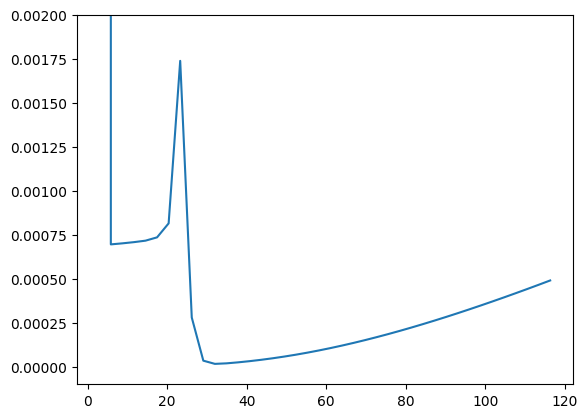

In [24]:
plt.plot(size_ratios, biases)
plt.ylim([-1e-4,0.002])

## Find limits for different shapelet kernels
- The limit will be larger for larger shapelet kernels

In [5]:
kernels = np.linspace(0.3,2.0,10)
hlr = 1.5

size_ratios = np.empty([len(kernels)])

for i, kernel in enumerate(kernels):
    nn = 128
    innit_scale = 0.01

    # create galaxy to be sampled by shear stamp objects
    sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux, trunc=trunc)

    bias = 1
    k = 1
    while bias > 1e-6:
        scale = init_scale * k
        # apply lensing shear to galaxy
        stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

        # define ia shear as a % of lensing
        ia = IaTransform(beta=0, center=[0,0], phi=np.radians(0), scale=scale, hlr=hlr)
        stamp.transform_grids(ia)

        # get galaxy array from stamp object
        gal_array = stamp.sample_galaxy(sersic_gal)
        # define PSF
        psf_array = np.zeros(stamp.shape)
        psf_array[nn // 2, nn // 2] = 1

        fpTask = fpfs.image.measure_source(psf_array, pix_scale=scale, sigma_arcsec=kernel)
        mms = fpTask.measure(gal_array, coords)
        mms = fpTask.get_results(mms)
        ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
        resp = np.average(ells['fpfs_R1E'])
        outer_shear = np.average(ells['fpfs_e1'])/resp
        
        bias = abs(outer_shear - AIA_fid)
        size_ratio = (nn/2 * scale) / hlr
        k *= 1.1
        
    size_ratios[i] = size_ratio

NameError: name 'init_scale' is not defined

In [ ]:
params = np.polyfit(kernels, size_ratios, 1)
plt.plot(kernels, size_ratios, lw=0, marker='o', ms=5)
plt.plot(kernels, params[0] * kernels + params[1], label='Best fit line')
plt.xlabel('Kernels')
plt.ylabel('Size Ratios')
plt.title('Size Ratios vs Kernels')
plt.show()

print(params)

NameError: name 'np' is not defined